(176, 256, 256)


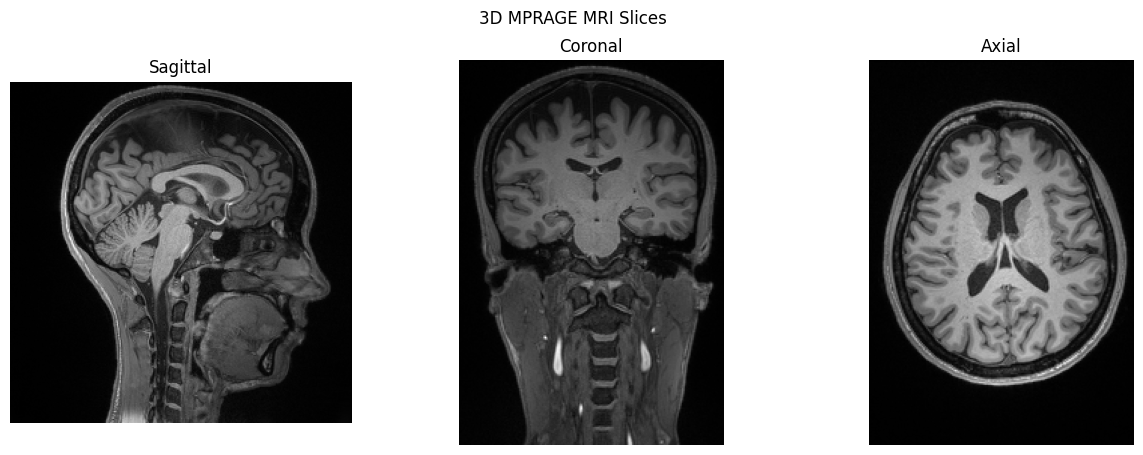

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
import nibabel as nib
from scipy.sparse.linalg import lsqr
import pandas as pd
from tqdm import tqdm

# Size of the 3D phantom
x_spins = 176
y_spins = 256
z_spins = 256

img = nib.load('mprage.nii')


# Get the data as a NumPy array
mprage = img.get_fdata()

# Create a figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display a slice from each dimension
# The np.flipud function is used to flip the images
axs[0].imshow(np.flipud(mprage[mprage.shape[0] // 2, :, :].T), cmap='gray')
axs[0].set_title('Sagittal')

axs[1].imshow(np.flipud(mprage[:, mprage.shape[1] // 2, :].T), cmap='gray')
axs[1].set_title('Coronal')

axs[2].imshow(np.flipud(mprage[:, :, 180].T), cmap='gray')
axs[2].set_title('Axial')

print(mprage.shape)

# Remove axes for all subplots
for ax in axs:
    ax.axis('off')
    
fig.suptitle('3D MPRAGE MRI Slices')
plt.show()

gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
g_multx = 20 # Gradient multiplication factor in the x direction
g_multy = 13.6 # Gradient multiplication factor in the y direction
Gx = 0.004755753 * g_multx  # Gradient strength in T/m
Gy = 0.004755753 * g_multy # Gradient strength in T/m
Gz = 0.004755753 * g_multx # Gradient strength in T/m
#B0 = 1.0  # B0 field in T

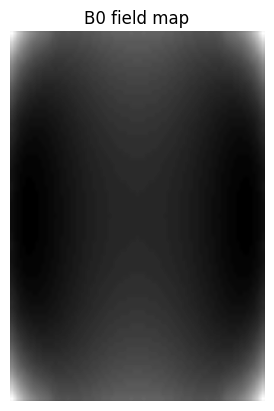

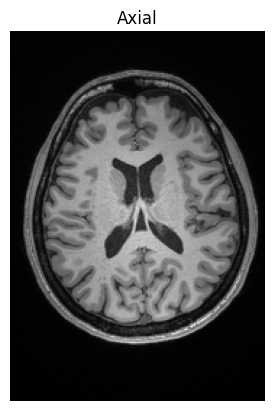

In [91]:
mprage_value = mprage.shape[0]
phantom = np.flipud(mprage[:, :, 180].T)
phantom = phantom.astype(dtype=np.complex128) # Make the phantom complex


B0_field_map = pd.read_csv('2Dslice.csv', header=None).values
gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
B0_field_map  = (B0_field_map * gamma)/(2*np.pi * 10000)  # Convert to Hz/T
B0_mean = np.mean(B0_field_map)  # Mean value of the B0 field map
B0_field_map -= B0_mean # subtract by the mean value of the B0 field map
B0_field_map *= 20 # B0 multiplier to see the distortion better
B0_field_map = resize(B0_field_map, (256, 176))

# Plot the B0 field map
fig, ax = plt.subplots()
ax.imshow(B0_field_map, cmap='gray')
ax.set_title('B0 field map')
ax.axis('off')
plt.show()

# Plot the phantom
fig, ax = plt.subplots()
ax.imshow(np.abs(phantom), cmap='gray')
ax.set_title('Axial')
ax.axis('off')
plt.show()

# 





0it [00:00, ?it/s]

256it [01:12,  3.52it/s]


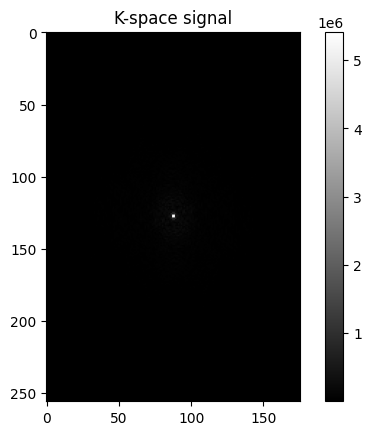

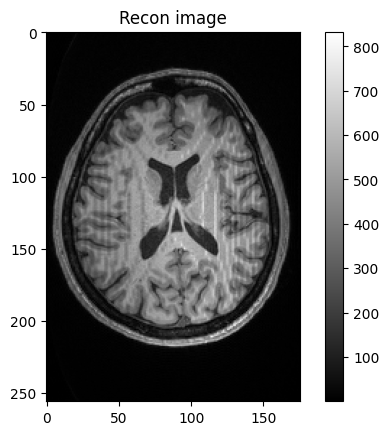

In [92]:


# Time intervals for the gradients
tau = 2e-3 # seconds

timex = np.linspace(-tau/2,tau/2,256)
timey = np.linspace(-tau/2,tau/2,176)

# Gradient fields (assuming same for x and y directions)
Gx_values = timex * Gx
Gy_values = timey * Gy

# k-space trajectory (assuming same for x and y directions)
kx_values = gamma * Gx_values 
ky_values = gamma * Gy_values

# Define field of view
FOV = .2  # meters
x_values = np.linspace(-FOV / 2, FOV / 2, 256)
y_values = np.linspace(-FOV / 2, FOV / 2, 176)
x_values, y_values = np.meshgrid(x_values, y_values, indexing='ij')  # Create 2D coordinate grid

# Flatten the phantom
phantom_flat = phantom.flatten()

# Flatten the arrays to make them 1D
x_values_flat = x_values.flatten()
y_values_flat = y_values.flatten()
B0_field_map_flat = B0_field_map.flatten()

# Allocate memory for flattened k-space
k_space_flat = np.zeros(176*256, dtype=np.complex128)



# Iterate through the kx and ky values
iterator = 0
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values):
        # Calculate the k-space value for this (kx, ky) point
        k_space_flat[iterator] = np.sum(phantom_flat * np.exp(-1j * (kx * x_values_flat + ky * y_values_flat + B0_field_map_flat * timey[j])))
        iterator += 1

# Reshape the flattened k-space data back into 2D matrix form
k_space = np.reshape(k_space_flat, (256, 176))

# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space), cmap='gray')
plt.title('K-space signal')
plt.colorbar()
plt.show()


# Apply inverse FFT
reconstructed_image = ifft2(k_space)
reconstructed_image_1 = fftshift(reconstructed_image)

# Plot the reconstructed image
plt.figure()
plt.imshow(np.abs(reconstructed_image_1), cmap='gray')
plt.title('Recon image')
plt.colorbar()
plt.show()

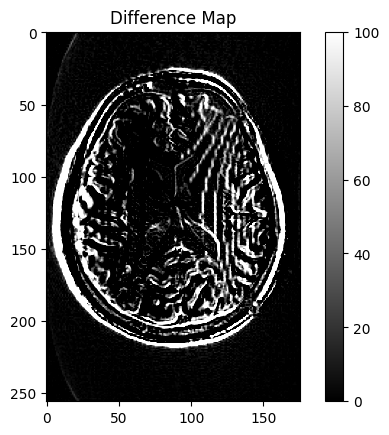

85.89404120467653


In [93]:
# Show difference map of the two images
difference_map = np.abs(reconstructed_image_1) - np.abs(phantom)
plt.figure()
plt.imshow(difference_map, cmap='gray', vmin=0, vmax=100.0)
plt.title('Difference Map')
plt.colorbar()
plt.show()

# Find rms of the the two images
rms = np.sqrt(np.mean(np.square(np.abs(reconstructed_image_1) - np.abs(phantom))))
print(rms)
